<a href="https://colab.research.google.com/github/Inceptix/Cassava-leaf-disease-classification/blob/master/Code/Modeling/Cassava_Disease_Classification(Base_Model_Eval).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Set up environment**

In [48]:
import math, re, os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from functools import partial
from sklearn.model_selection import train_test_split
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


In [49]:
!pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-r1b0ekia
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-r1b0ekia
  Running command git submodule update --init --recursive -q
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-cp36-none-any.whl size=20030 sha256=908264d92353c589e17fbee913466985d95f0d640817d0bc72e2f5d6dc1ad72f
  Stored in directory: /tmp/pip-ephem-wheel-cache-qczzdshr/wheels/de/2b/fd/29a6d33edb8c28bc7d94e95ea1d39c9a218ac500a3cfb1b197
Successfully built image-classifiers


In [50]:
from classification_models.tfkeras import Classifiers

**Detect GPUs**

In [51]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Device: grpc://10.36.39.26:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.36.39.26:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.36.39.26:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of replicas: 8


In [52]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [512, 512]
CLASSES = ['0', '1', '2', '3', '4']
EPOCHS = 25

# need to load from a google cloud bucket or you will get
# File system scheme '[local]' error
GCS_PATH = 'gs://kds-9254a9aba4b37289f07bbbbe4e2af5c952dd2d811a2c823340ca8091'

In [53]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [54]:
# TRAINING_PATH = "/content/gdrive/My Drive/Project in DS Class/cassava-leaf-disease-classification/train_tfrecords/ld_train*.tfrec"
# TESTING_PATH = "/content/gdrive/My Drive/Project in DS Class/cassava-leaf-disease-classification/test_tfrecords/ld_test*.tfrec"
TRAINING_PATH = GCS_PATH + '/train_tfrecords/ld_train*.tfrec' 
TESTING_PATH = GCS_PATH + '/test_tfrecords/ld_test*.tfrec'
TRAINING_FILENAMES, VALID_FILENAMES = train_test_split(
    tf.io.gfile.glob(TRAINING_PATH),
    test_size=0.35, random_state=5
)

TEST_FILENAMES = tf.io.gfile.glob(TESTING_PATH)

In [55]:
# decode the images
def decode_image(image):
    # decode with 3 channels (RGB)
    image = tf.image.decode_jpeg(image, channels=3)
    # normalize so each image's pixels are from 0 - 255 to 0 - 1 range
    image = tf.cast(image, tf.float32) / 255.0
    # apply the normalized pixels value on the images
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example, labeled):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    } if labeled else {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    # decode the images
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    if labeled:
        label = tf.cast(example['target'], tf.int32)
        return image, label
    idnum = example['image_name']
    return image, idnum
  
def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    return dataset

**Augmentation**

In [56]:
# trying out new augmentation techniques

# orignal
def data_augment_flip_left_right(image, label):
    # Thanks to the dataset.prefetch(AUTO) statement in the following function this happens essentially for free on TPU. 
    # Data pipeline code is executed on the "CPU" part of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    return image, label

def data_augment_flip_up_down(image, label):
    image = tf.image.random_flip_up_down(image)
    return image, label

def data_augment_random_hue(image, label):
    # Thanks to the dataset.prefetch(AUTO) statement in the following function this happens essentially for free on TPU. 
    # Data pipeline code is executed on the "CPU" part of the TPU while the TPU itself is computing gradients.
    random_delta = random.uniform(0, 0.5)
    image = tf.image.random_hue(image, max_delta=random_delta)
    return image, label

def data_augment_random_jpeg_quality(image, label):
    # Thanks to the dataset.prefetch(AUTO) statement in the following function this happens essentially for free on TPU. 
    # Data pipeline code is executed on the "CPU" part of the TPU while the TPU itself is computing gradients.
    random_min = random.uniform(0, 100)
    random_max = random.uniform(0, 100)
    image = tf.image.random_jpeg_quality(image, min_jpeg_quality=random_min, max_jpeg_quality=random_max)
    return image, label

def data_augment_random_saturation(image, label):
    # Thanks to the dataset.prefetch(AUTO) statement in the following function this happens essentially for free on TPU. 
    # Data pipeline code is executed on the "CPU" part of the TPU while the TPU itself is computing gradients.
    random_lower = random.uniform(0,100)
    random_upper = random.uniform(0,100)
    image = tf.image.random_saturation(image, lower=random_lower, upper=random_upper)
    return image, label

In [57]:
data_augment_sequence = (data_augment_flip_left_right, data_augment_flip_up_down)

**Data Loading Methods**

In [58]:
def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)  

    # trying out different data augmentation techniques
    # dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE) 
   # for technique in data_augment_sequence:
      #dataset = dataset.map(technique, num_parallel_calls=AUTOTUNE) 
    # original
    # dataset = dataset.map(data_augment_flip_left_right, num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALID_FILENAMES, labeled=True, ordered=ordered) 
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [59]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALID_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)

print('Dataset: {} training images, {} validation images, {} (unlabeled) test images'.format(
    NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 13380 training images, 8017 validation images, 1 (unlabeled) test images


**Build the model**

In [60]:
lr_scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5, 
    decay_steps=10000, 
    decay_rate=0.9)

In [61]:
with strategy.scope():       
    img_adjust_layer = tf.keras.layers.Lambda(tf.keras.applications.resnet50.preprocess_input, input_shape=[*IMAGE_SIZE, 3])
    
    # base
    # use base_model.trainable = False
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    # customizable model
    model = tf.keras.Sequential([
        tf.keras.layers.BatchNormalization(renorm=True),
        img_adjust_layer,
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(8, activation='relu'),
        #tf.keras.layers.BatchNormalization(renorm=True),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')  
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler, epsilon=0.001),
        loss='sparse_categorical_crossentropy',  
        metrics=['sparse_categorical_accuracy'])

In [62]:
# load our training dataset for EDA
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)

In [63]:
# load our validation dataset for EDA
validation_dataset = get_validation_dataset()
validation_dataset = validation_dataset.unbatch().batch(20)
valid_batch = iter(validation_dataset)

In [64]:
# load our test dataset for EDA
testing_dataset = get_test_dataset()
testing_dataset = testing_dataset.unbatch().batch(20)
test_batch = iter(testing_dataset)

**Train the model**

In [65]:
# load data
train_dataset = get_training_dataset()
valid_dataset = get_validation_dataset()

In [66]:
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALID_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE

history = model.fit(train_dataset, 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    epochs=EPOCHS,
                    validation_data=valid_dataset,
                    validation_steps=VALID_STEPS)

Epoch 1/25
104/104 [==============================] - 84s 640ms/step - loss: 2.6501 - sparse_categorical_accuracy: 0.1095 - val_loss: 2.3748 - val_sparse_categorical_accuracy: 0.1153
Epoch 2/25
104/104 [==============================] - 55s 529ms/step - loss: 2.2326 - sparse_categorical_accuracy: 0.1109 - val_loss: 1.7921 - val_sparse_categorical_accuracy: 0.1153
Epoch 3/25
104/104 [==============================] - 55s 528ms/step - loss: 1.7100 - sparse_categorical_accuracy: 0.1203 - val_loss: 1.4971 - val_sparse_categorical_accuracy: 0.2684
Epoch 4/25
104/104 [==============================] - 55s 529ms/step - loss: 1.4533 - sparse_categorical_accuracy: 0.3462 - val_loss: 1.3696 - val_sparse_categorical_accuracy: 0.5108
Epoch 5/25
104/104 [==============================] - 55s 530ms/step - loss: 1.3650 - sparse_categorical_accuracy: 0.5234 - val_loss: 1.3077 - val_sparse_categorical_accuracy: 0.5712
Epoch 6/25
104/104 [==============================] - 55s 532ms/step - loss: 1.3116 -

**Use model.Sequential to preprocess images and add that images to the training data**

Link: https://www.google.com/url?q=https://www.tensorflow.org/tutorials/images/data_augmentation&sa=D&source=calendar&usd=2&usg=AOvVaw2uVg2QOUsHBQ2tAoiG5H1G

**Evaluation of Base Model**

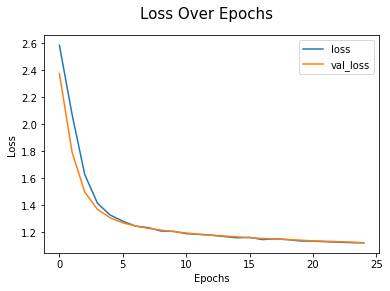

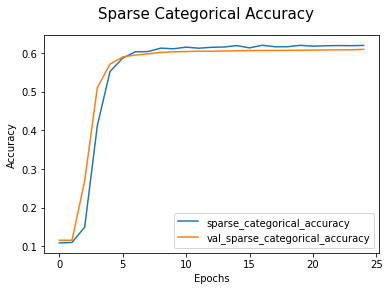

In [67]:
#print(history.history.keys())

# create learning curves to evaluate model performance
history_frame = pd.DataFrame(history.history)

fig = plt.figure()
fig.suptitle("Loss Over Epochs", fontsize=15)
plt.plot(history_frame.loc[:, ['loss', 'val_loss']])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

fig = plt.figure()
fig.suptitle("Sparse Categorical Accuracy", fontsize=15)
plt.plot(history_frame.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']])
plt.legend(['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [68]:
from sklearn.metrics import confusion_matrix

#reload validation set in order
valid_ordered = get_validation_dataset(ordered=True)

#scrape labels from tuples
validation_labels = np.concatenate([y for x, y in valid_ordered], axis=0) #image is x, label is y

#print lengths
# print(len(validation_labels))
# print(NUM_VALIDATION_IMAGES)

#get predictions
label_pred = model.predict(valid_ordered)

label_pred = np.argmax(label_pred, axis=1)

#confusion matrix takes grand truth first, and then the predictions
conf_matrix = confusion_matrix(validation_labels, label_pred)
print("Confusion Matrix")
print(conf_matrix)

#accuracy
acc = np.sum(conf_matrix.diagonal()) / np.sum(conf_matrix)
print("\nModel Accuracy: {a}\n".format(a = acc))

#Distribution matrix
dist_mat = confusion_matrix(validation_labels, validation_labels)
print("Distribution Matrix")
print(dist_mat)

Confusion Matrix
[[   0   12   22  358    0]
 [   0   13   51  759    0]
 [   0    3   15  910    0]
 [   0    4   20 4852    0]
 [   0   23   47  927    1]]

Model Accuracy: 0.6088312336285393

Distribution Matrix
[[ 392    0    0    0    0]
 [   0  823    0    0    0]
 [   0    0  928    0    0]
 [   0    0    0 4876    0]
 [   0    0    0    0  998]]


**Thoughts on the Model**

As visible from the confusion matrix, our model seems to classify most images as Type 3, the Cassava Mosaic Disease. Infact our accuracy is only as high as it is, because most of the images are of this type.  Oddly enough I thought this would be one of the easier to detect, however it seems that our model is unfairly leaning towards this category, but what can be causing the confusion?

Lets take a look at some images.

In [69]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_plant(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_plant(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()




						Valid Batch


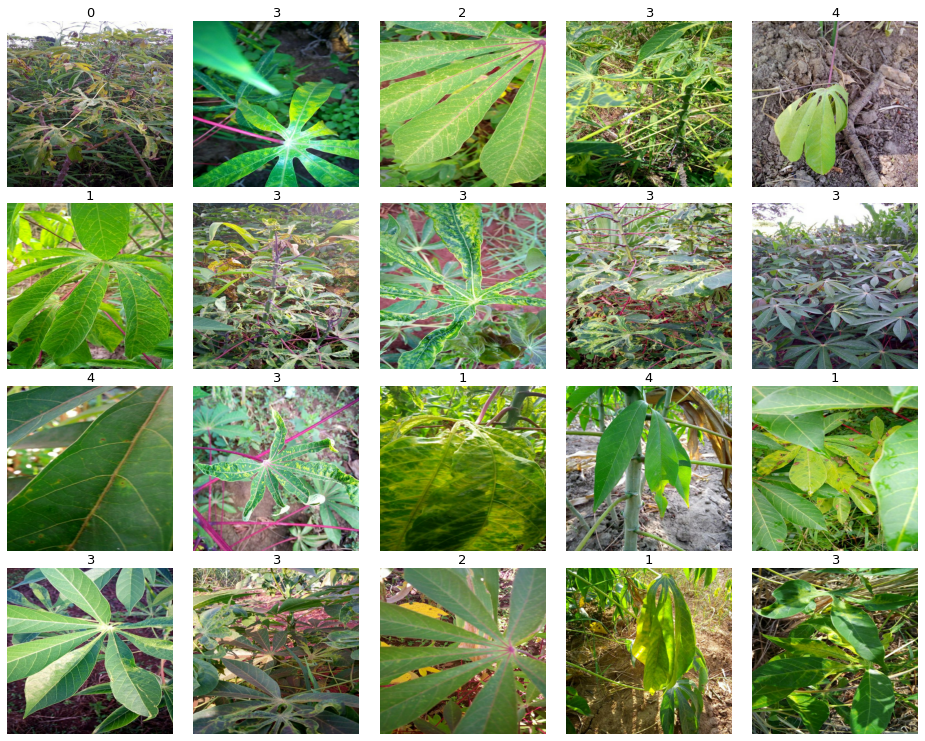

In [70]:
#call the methods
#print some of the validation set
print("\n\t\t\t\t\t\tValid Batch")
display_batch_of_images(next(valid_batch))

From the images above it is plain to see where the confusion is coming from.  There is no form of consistency in the images, and some are not even of the leaves themselves.  This gives us an opportunity to experiment with augmentation and albumentations.  

One thing that Jonathan brought to my attention was Canny Edge detection which helps the identifyin the leaves themselves and draws a bounding box around them.  This could help the machine focus on the correct part of the image(i.e. cutting down on noise).

EfficientNet Noisy Student

**Another Example of Noise**

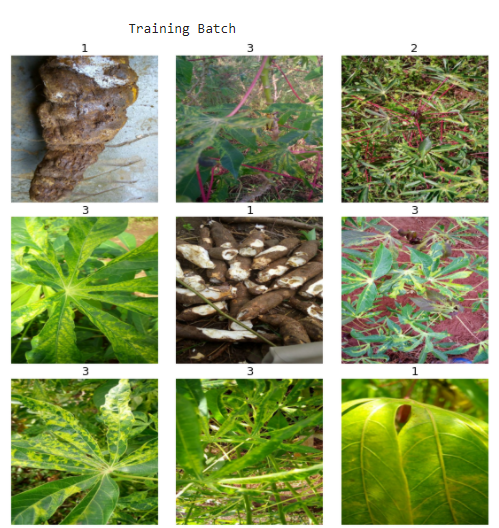

**Sources**

A lot of credit goes to the Getting Started Notebook by Jesse Mostipak (https://www.kaggle.com/jessemostipak/getting-started-tpus-cassava-leaf-disease)

This proved to be instrumental in getting ourselves off the ground and pointed in the right direction.